Make a copy of this notebook and rename using your USERID in the following format, 2017CSZ8058

Give editor access to keshavkolluru@gmail.com, vishalsaley114@gmail.com and kartikeya.badola@gmail.com


# Imports

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.2 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
## DONT CHANGE THIS CELL 
# this is currently the same as dev.data.txt
!wget http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.data.txt

--2021-10-25 17:26:28--  http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.data.txt
Resolving www.cse.iitd.ac.in (www.cse.iitd.ac.in)... 103.27.9.152
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.data.txt [following]
--2021-10-25 17:26:28--  https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.data.txt
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63639 (62K) [text/plain]
Saving to: ‘test.data.txt’

test.data.txt       100%[===================>]  62.15K   140KB/s    in 0.4s    

2021-10-25 17:26:29 (140 KB/s) - ‘test.data.txt’ saved [63639/63639]



In [ ]:
# !gdown https://drive.google.com/u/0/uc?id=1T4_jZYqshPSJJh6PlvMU0pyCG7Rp1NTy&export=download
# # 69.5 wic

In [ ]:
# !gdown https://drive.google.com/u/0/uc?id=1eKwhl0nDO6ntcUk9VabQEwyWUkYA1QEg&export=download
# 71.15

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1aYQnbxJw3gIj67QKNQKkbG8KhvDHSg_S&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1aYQnbxJw3gIj67QKNQKkbG8KhvDHSg_S
To: /content/best-bert-wsd-params.pt
100% 438M/438M [00:02<00:00, 172MB/s]


# Data Read

In [ ]:
import sys
import re
def cleaning(text):
  text= text.lower()
  text=text.strip()
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  replace_dot = re.compile("\.")
  text = replace_dot.sub(' ', text)
  replace_q = re.compile("\?")
  text = replace_q.sub('', text)
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub('' , text)
  text = BAD_SYMBOLS_RE.sub('',text)  
  return text

In [ ]:
import pandas as pd
df_val = pd.read_csv('test.data.txt', sep ="\t",names = ['word', 'pos', 'position','sentence1','sentence2'])
# df_val = pd.read_json('test.en-en.data')
df_val['sentence1']=df_val['sentence1'].apply(cleaning)
df_val['sentence2']=df_val['sentence2'].apply(cleaning)

In [ ]:
test_df = pd.DataFrame()
test_df['sentence1'] = df_val['sentence1']
test_df['sentence2'] = df_val['sentence2']

In [ ]:
test_df['sentence1'] = test_df['sentence1'].astype(str)
test_df['sentence2'] = test_df['sentence2'].astype(str)

In [ ]:
test_df = test_df[(test_df['sentence1'].str.split().str.len() > 0) & (test_df['sentence2'].str.split().str.len() > 0)]

# Model

In [ ]:
import os

import time
import datetime

import torch
torch.cuda.empty_cache()
import torch.optim as O
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

import pandas as pd
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#Reproducing same results
SEED = 2021

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

class DataBert(Dataset):

  def __init__(self, test_df):
    self.test_df = test_df
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.test_data = None
    self.init_data()

  def init_data(self):
    self.test_data = self.load_data(self.test_df)

  def load_data(self, df):
    MAX_LEN = 100
    token_ids = []
    mask_ids = []
    seg_ids = []

    s1_list = df['sentence1'].to_list()
    s2_list = df['sentence2'].to_list()

    for (s1, s2) in zip(s1_list, s2_list):
      s1_id = self.tokenizer.encode(s1, add_special_tokens = False)
      s2_id = self.tokenizer.encode(s2, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + s1_id + [self.tokenizer.sep_token_id] + s2_id + [self.tokenizer.sep_token_id]
      s1_len = len(s1_id)
      s2_len = len(s2_id)

      segment_ids = torch.tensor([0] * (s1_len + 2) + [1] * (s2_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (s1_len + s2_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)

    dataset = TensorDataset(token_ids, mask_ids, seg_ids)
    print(len(dataset))
    return dataset

  def get_data_loaders(self):
    test_loader = DataLoader(self.test_data)
    return test_loader

In [ ]:
from transformers import BertForSequenceClassification
from transformers import BertConfig
test_dataset = DataBert(test_df)
test_loader = test_dataset.get_data_loaders()
config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.1, num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config =config)
path='/content/best-bert-wsd-params.pt'
# path='/content/best-bert-wsd-params (2).pt'
checkpoint = torch.load(path)
options = checkpoint['options']
accuracy = checkpoint['accuracy']
model.load_state_dict(checkpoint['model_dict'], strict=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

638


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [ ]:
model.eval()
model.to(device)
predictions = []
def predict(model, test_loader):
  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids) in enumerate(test_loader):
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      outputs  = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predictions.append(logits)                             
    return predictions

In [ ]:
outputfile = "output.txt"
ans = ""
file1 = open(outputfile,"w+")
predictions = predict(model,test_loader)
for i in range(len(test_df)):
  output = np.argmax(predictions[i]).flatten()
  if output[0] == 1:
    ans = "T"
  else:
    ans = "F"
  file1.write(ans)
  file1.write("\n")  
file1.close()

In [ ]:
## DONT CHANGE THIS CELL
# Your testing code must produce a file output.txt with predictions as T and F in each line

## Final Evaluation 
# this is currently the same as dev.gold.txt
!wget http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.gold.txt
correct, total = 0., 0.
for prediction, gold in zip(open('output.txt'), open('test.gold.txt')):
  prediction, gold = prediction.strip(), gold.strip()
  total += 1
  if prediction == gold:
    correct += 1

## Report this as the final validation performance 
print('Performance = ', (correct/total))

--2021-10-25 17:28:01--  http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.gold.txt
Resolving www.cse.iitd.ac.in (www.cse.iitd.ac.in)... 103.27.9.152
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.gold.txt [following]
--2021-10-25 17:28:02--  https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/test.gold.txt
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1276 (1.2K) [text/plain]
Saving to: ‘test.gold.txt’

test.gold.txt       100%[===================>]   1.25K  --.-KB/s    in 0s      

2021-10-25 17:28:02 (63.5 MB/s) - ‘test.gold.txt’ saved [1276/1276]

Performance =  0.7163009404388715


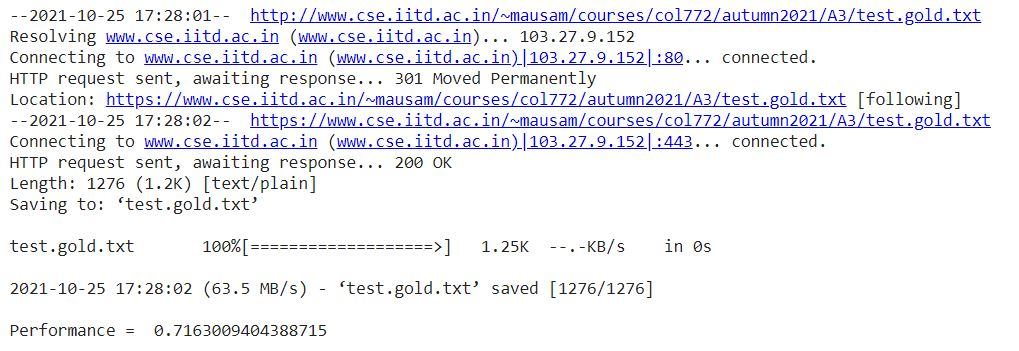